In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [44]:
engine = create_engine('postgres:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

/home/ben/.environments/stats/lib/python3.8/site-packages/sqlalchemy/dialects/postgresql/base.py:3470: SAWarning: Predicate of partial index files_size ignored during reflection
  util.warn(


In [15]:
start_date = '2020-10-01'
start_time = '2020-10-01 00:00:00'
end_date = '2020-12-31'
end_time = '2021-01-01 00:00:00'
one_year_ago = '2020-01-01'

In [4]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,4643950


In [5]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at::date < '{end_date}'
""", conn)

,downloads_to_date
0,21871144


In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,736605


In [65]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_json_downloads
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_json_downloads
0,50894


In [7]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,344206


In [8]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{one_year_ago}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2020-01-01,1079669
1,2020-02-01,985288
2,2020-03-01,1300742
3,2020-04-01,1239451
4,2020-05-01,1271968
5,2020-06-01,1170659
6,2020-07-01,1102139
7,2020-08-01,1737186
8,2020-09-01,1653471
9,2020-10-01,1850781


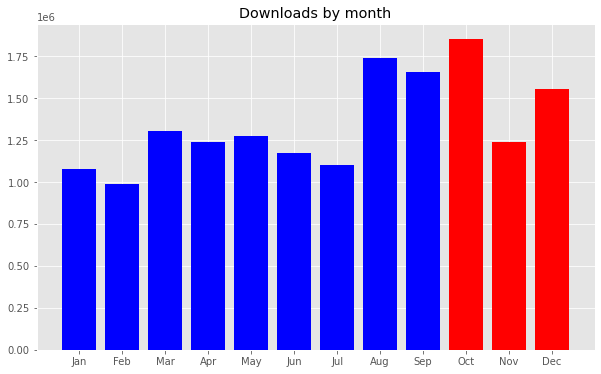

In [9]:
plt.rcParams["figure.figsize"] = (10, 6)

downloads = {
    'Jan': downloads_by_month.c[0],
    'Feb': downloads_by_month.c[1],
    'Mar': downloads_by_month.c[2],
    'Apr': downloads_by_month.c[3],
    'May': downloads_by_month.c[4],
    'Jun': downloads_by_month.c[5],
    'Jul': downloads_by_month.c[6],
    'Aug': downloads_by_month.c[7],
    'Sep': downloads_by_month.c[8],
    'Oct': downloads_by_month.c[9],
    'Nov': downloads_by_month.c[10],
    'Dec': downloads_by_month.c[11],
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(downloads)), downloads.values(), color=colors)
plt.title('Downloads by month')
plt.xticks(range(len(downloads)), list(downloads.keys()))

plt.savefig('downloads-by-month.png')

plt.show()

In [10]:
downloads_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS d, COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY d
    ORDER BY d
""", conn)

downloads_by_day

,d,downloads
0,2020-10-01,50806
1,2020-10-02,60169
2,2020-10-03,60070
3,2020-10-04,59506
4,2020-10-05,59478
...,...,...
87,2020-12-27,44174
88,2020-12-28,48286
89,2020-12-29,56938
90,2020-12-30,57811


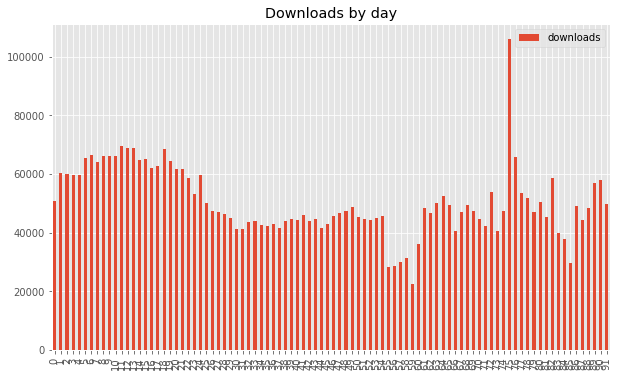

In [11]:
p = downloads_by_day.plot.bar(title='Downloads by day')
p.figure.savefig('downloads-by-day.png')

In [16]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
""", conn)

searches = df.values[0][0]
searches

37578502

In [17]:
pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) AS month, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,searches
0,2020-10-01,14590152
1,2020-11-01,13438773
2,2020-12-01,9549577


In [18]:
searches_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS day, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY day
    ORDER BY day
""", conn)

searches_by_day

,day,searches
0,2020-10-01,497162
1,2020-10-02,480572
2,2020-10-03,467695
3,2020-10-04,452246
4,2020-10-05,483030
...,...,...
87,2020-12-27,256675
88,2020-12-28,268764
89,2020-12-29,301496
90,2020-12-30,305073


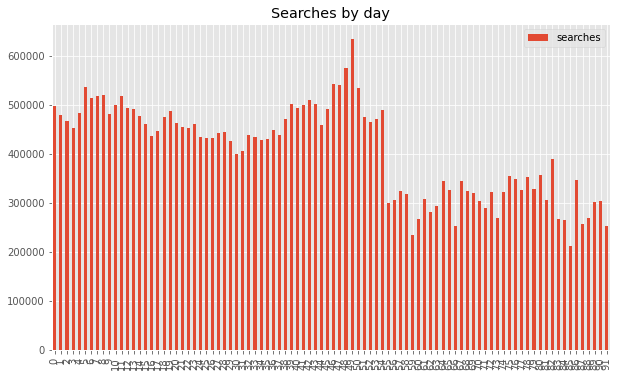

In [19]:
p = searches_by_day.plot.bar(title='Searches by day')
p.figure.savefig('searches-by-day.png')

In [20]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,20277 days 19:38:21.302368


In [21]:
pd.read_sql(f"""
    SELECT date_trunc('month', d.accessed_at) as month, JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_in_month
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{one_year_ago}' and '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,time_saved_in_month
0,2020-01-01,6498 days 01:17:55.398020
1,2020-02-01,7218 days 00:56:02.558966
2,2020-03-01,8467 days 12:37:48.921004
3,2020-04-01,7988 days 02:21:24.684736
4,2020-05-01,9265 days 22:22:04.862527
5,2020-06-01,9093 days 16:42:32.583684
6,2020-07-01,8705 days 13:01:40.887174
7,2020-08-01,11232 days 03:11:23.647317
8,2020-09-01,9514 days 20:28:08.213492
9,2020-10-01,8045 days 18:44:37.806206


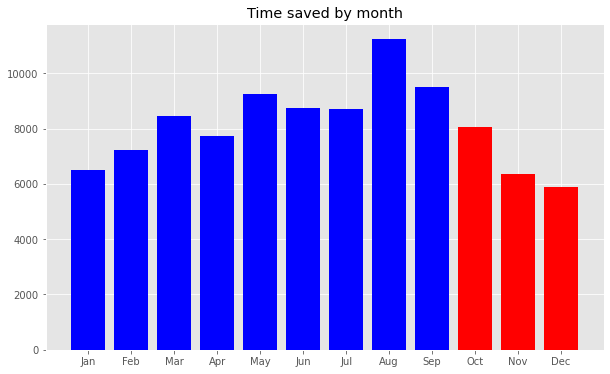

In [22]:
time_saved = {
    'Jan': 6498,
    'Feb': 7218,
    'Mar': 8467,
    'Apr': 7738,
    'May': 9265,
    'Jun': 8727,
    'Jul': 8705,
    'Aug': 11233,
    'Sep': 9514,
    'Oct': 8045,
    'Nov': 6349,
    'Dec': 5882,
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(time_saved)), time_saved.values(), color=colors)
plt.title('Time saved by month')
plt.xticks(range(len(time_saved)), list(time_saved.keys()))

plt.savefig('time-saved-by-month.png')

plt.show()

In [24]:
top_10_downloads = pd.read_sql(f"""
    select b.package, count(*) c
    from downloads d
    join files f on f.filename = d.filename
    join builds b on b.build_id = f.build_id
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by b.package
    order by c desc
    limit 10;
""", conn)

top_10_downloads

,package,c
0,webrtcvad-wheels,356784
1,numpy,284700
2,requests,91968
3,pyyaml,86810
4,cffi,84540
5,octoprint-firmwarecheck,82803
6,websocket-client,81288
7,sentry-sdk,79387
8,filetype,78924
9,semantic-version,74333


In [25]:
print("<ol>")
for i, row in top_10_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/webrtcvad-wheels'>webrtcvad-wheels</a></strong> (356,784)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (284,700)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (91,968)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (86,810)</li>
<li><strong><a href='https://www.piwheels.org/project/cffi'>cffi</a></strong> (84,540)</li>
<li><strong><a href='https://www.piwheels.org/project/octoprint-firmwarecheck'>octoprint-firmwarecheck</a></strong> (82,803)</li>
<li><strong><a href='https://www.piwheels.org/project/websocket-client'>websocket-client</a></strong> (81,288)</li>
<li><strong><a href='https://www.piwheels.org/project/sentry-sdk'>sentry-sdk</a></strong> (79,387)</li>
<li><strong><a href='https://www.piwheels.org/project/filetype'>filetype</a></strong> (78,924)</li>
<li><strong><a href='https://www.piwheels.org

In [35]:
top_10_searches = pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_searches

,package,c
0,pip,5664832
1,wheel,2200871
2,pyrogram,1368093
3,setuptools,1036791
4,webrtcvad-wheels,774656
5,cryptoadvance-specter,618384
6,numpy,502596
7,youtube-dl,499680
8,requests,478480
9,certifi,385542


In [34]:
print("<ol>")
for pkg, c in top_10_searches.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (5,664,832)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (2,200,871)</li>
<li><strong><a href='https://www.piwheels.org/project/pyrogram'>pyrogram</a></strong> (1,368,093)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (1,036,791)</li>
<li><strong><a href='https://www.piwheels.org/project/webrtcvad-wheels'>webrtcvad-wheels</a></strong> (774,656)</li>
<li><strong><a href='https://www.piwheels.org/project/cryptoadvance-specter'>cryptoadvance-specter</a></strong> (618,384)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (502,596)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (499,680)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (478,480)</li>
<li><strong><a href='https://www.piwheels.org/proj

In [37]:
top_10_project_pages = pd.read_sql(f"""
    select package, count(*) c
    from project_page_hits
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_pages

,package,c
0,opencv-python,1749
1,numpy,1129
2,opencv-contrib-python,1062
3,scipy,769
4,tensorflow,755
5,qhub-ops,693
6,pillow,462
7,pip,394
8,pandas,326
9,grpcio,309


In [40]:
print("<ol>")
for pkg, c in top_10_project_pages.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (1,749)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (1,129)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (1,062)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (769)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (755)</li>
<li><strong><a href='https://www.piwheels.org/project/qhub-ops'>qhub-ops</a></strong> (693)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (462)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (394)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pandas</a></strong> (326)</li>
<li><strong><a href='https://www.piwheels.org/project/grpcio'>grpcio</a></strong> (309)</li>
</ol>


In [41]:
top_10_project_json = pd.read_sql(f"""
    select package, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_json

,package,c
0,scipy,324
1,numpy,108
2,opencv-python,68
3,tensorflow,58
4,imagecodecs,38
5,pycparser,36
6,future,31
7,scikit-image,31
8,opencv-contrib-python,29
9,urllib3,28


In [66]:
print("<ol>")
for pkg, c in top_10_project_json.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (324)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (108)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (68)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (58)</li>
<li><strong><a href='https://www.piwheels.org/project/imagecodecs'>imagecodecs</a></strong> (38)</li>
<li><strong><a href='https://www.piwheels.org/project/pycparser'>pycparser</a></strong> (36)</li>
<li><strong><a href='https://www.piwheels.org/project/future'>future</a></strong> (31)</li>
<li><strong><a href='https://www.piwheels.org/project/scikit-image'>scikit-image</a></strong> (31)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (29)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (28)<

In [67]:
pd.read_sql(f"""
    select count(distinct(package)) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,c
0,46635


In [69]:
pd.read_sql(f"""
    select user_agent, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by user_agent
    order by c desc
""", conn)

,user_agent,c
0,mozilla,49330
1,serpstatbot,597
2,ccbot,445
3,keybot translation-search-machine,247
4,python-requests,219
5,mauibot (crawler.feedback+dc@gmail.com),49
6,bl.uk_lddc_bot,1
7,whatsapp,1
8,chrome,1
9,e3_living,1


In [45]:
os_usage = pd.read_sql(f"""
    select os_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by os_name
    order by c desc
""", conn)

os_usage

,os_name,c
0,Linux,37555389
1,Windows,12536
2,Darwin,9387
3,FreeBSD,1158
4,None,21
5,CYGWIN_NT-10.0-18363,9
6,CYGWIN_NT-10.0-19041,2


In [46]:
os_usage.values[0][1] / searches

0.9993849408898737

In [47]:
distro_usage = pd.read_sql(f"""
    select distro_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    group by distro_name
    order by c desc
    limit 5
""", conn)

distro_usage

,distro_name,c
0,Raspbian GNU/Linux,34281746
1,Debian GNU/Linux,2714365
2,Ubuntu,303469
3,Red Hat Enterprise Linux Server,154707
4,Alpine Linux,29040


In [48]:
debian_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    order by c desc
    limit 5
""", conn)

debian_usage

,c
0,36996111


In [72]:
debian_usage / searches

,c
0,0.984502


In [49]:
ubuntu_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name = 'Ubuntu'
    order by c desc
    limit 5
""", conn)

ubuntu_usage

,c
0,303469


In [50]:
debian = debian_usage.values[0][0]
others = searches - debian

distro_usage = {
    'Debian / Raspbian / PiOS': debian,
    'Others': others,
}

distro_usage

{'Debian / Raspbian / PiOS': 36996111, 'Others': 582391}

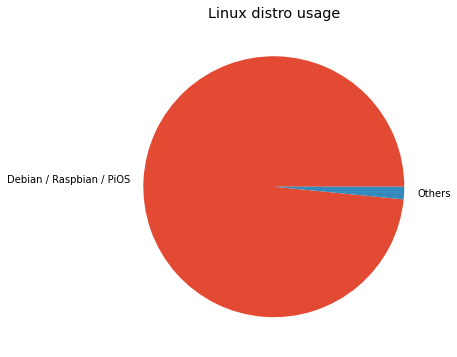

In [51]:
plt.pie(distro_usage.values(), labels=distro_usage.keys())
plt.title('Linux distro usage')

plt.savefig('distro-usage.png')

plt.show()

In [52]:
distro_versions = pd.read_sql(f"""
    select distro_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version in ('8', '9', '10')
    group by distro_version
    order by c desc
""", conn)

distro_versions

,distro_version,c
0,10,31176013
1,9,5728825
2,8,1395


In [53]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

10 84.5%
9 15.5%
8 0.0%


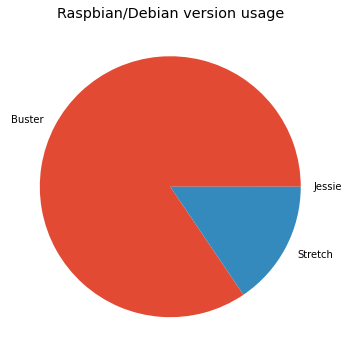

In [54]:
version_names = {'10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c, labels=[version_names[v] for v in distro_versions.distro_version])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [55]:
arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by arch
    order by c desc
""", conn)

arch

,arch,c
0,armv7l,33154903
1,armv6l,1751674
2,aarch64,1586916
3,x86_64,993047
4,i686,46666
5,armv8l,30659
6,AMD64,12536
7,amd64,1158
8,ppc64le,504
9,s390x,368


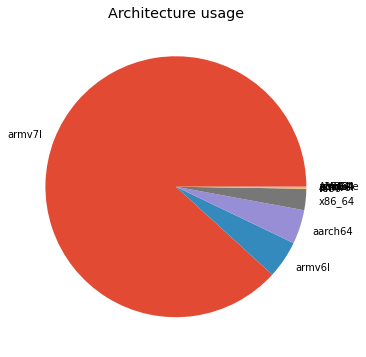

In [56]:
plt.pie(arch.c, labels=arch.arch)
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [57]:
arm_arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    group by arch
    order by c desc
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 91.0%
armv6l 4.8%
aarch64 4.2%


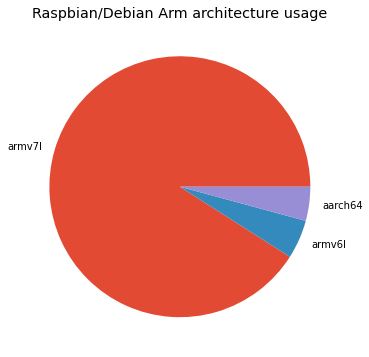

In [58]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('Raspbian/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [59]:
py_vers = pd.read_sql(f"""
    select substring(py_version from 1 for 3) pyver, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and py_name = 'CPython'
    group by pyver
    order by c desc
    limit 5
""", conn)

py_vers

,pyver,c
0,3.7,23302294
1,2.7,8379969
2,3.8,3703849
3,3.5,1293636
4,3.9,462242


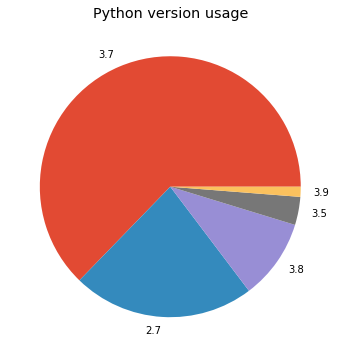

In [60]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

In [85]:
total = sum(row[1] for row in py_vers.values)

for ver, c in py_vers.values:
    print(ver, f'{100 * (c / total):.2f}%')

3.7 62.74%
2.7 22.56%
3.8 9.97%
3.5 3.48%
3.9 1.24%


0.22561981735496672

In [61]:
pip_versions = pd.read_sql(f"""
    select installer_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and installer_version is not null
    group by installer_version
    order by c desc
""", conn)

pip_versions[:10]

,installer_version,c
0,18.1,11154383
1,20.2.4,8834934
2,20.2.3,3580562
3,19.3.1,2751545
4,20.3.1,1996232
5,9.0.1,1756192
6,20.3.3,1661439
7,20.2.2,1023965
8,20.0.2,810209
9,20.2,730652


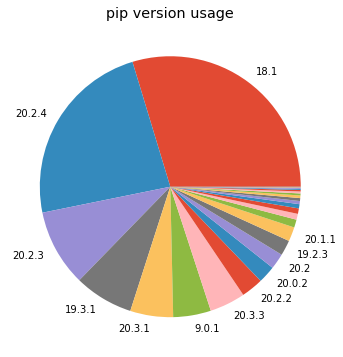

In [62]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [63]:
setuptools_versions = pd.read_sql(f"""
    select setuptools_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and setuptools_version is not null
    group by setuptools_version
    order by c desc
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,16360597
1,50.3.2,3664654
2,41.2.0,2994652
3,41.5.1,2539266
4,50.3.0,1484216
5,44.1.1,1246488
6,49.2.1,932348
7,49.2.0,857204
8,51.0.0,716149
9,49.6.0,583585


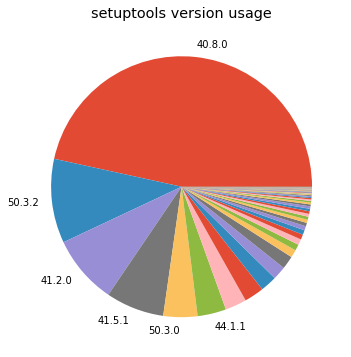

In [64]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()